# The Data

In [28]:

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, roc_auc_score, f1_score, roc_curve, classification_report, 
                             cohen_kappa_score)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning


In [29]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")


In [30]:
print(ha.head()) 
print(ha.info()) 
print(ha.describe())

   age  sex  cp  trtbps  chol  restecg  thalach  output
0   63    1   3     145   233        0      150       1
1   37    1   2     130   250        1      187       1
2   56    1   1     120   236        1      178       1
3   57    0   0     120   354        1      163       1
4   57    1   0     140   192        1      148       1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   age      273 non-null    int64
 1   sex      273 non-null    int64
 2   cp       273 non-null    int64
 3   trtbps   273 non-null    int64
 4   chol     273 non-null    int64
 5   restecg  273 non-null    int64
 6   thalach  273 non-null    int64
 7   output   273 non-null    int64
dtypes: int64(8)
memory usage: 17.2 KB
None
              age         sex          cp      trtbps        chol     restecg     thalach      output
count  273.000000  273.000000  273.000000  273.000000 

In [31]:
ha.dropna(inplace=True)
ha[["sex", "cp", "restecg"]] = ha[["sex", "cp", "restecg"]].astype("object")
ha["output"] = ha["output"].astype(int)
print(ha.describe())

              age      trtbps        chol     thalach      output
count  273.000000  273.000000  273.000000  273.000000  273.000000
mean    54.347985  132.098901  246.860806  149.446886    0.534799
std      9.163134   17.700358   52.569726   23.240707    0.499704
min     29.000000   94.000000  126.000000   71.000000    0.000000
25%     47.000000  120.000000  211.000000  133.000000    0.000000
50%     56.000000  130.000000  240.000000  152.000000    1.000000
75%     61.000000  140.000000  275.000000  166.000000    1.000000
max     77.000000  200.000000  564.000000  202.000000    1.000000
              age      trtbps        chol     thalach      output
count  273.000000  273.000000  273.000000  273.000000  273.000000
mean    54.347985  132.098901  246.860806  149.446886    0.534799
std      9.163134   17.700358   52.569726   23.240707    0.499704
min     29.000000   94.000000  126.000000   71.000000    0.000000
25%     47.000000  120.000000  211.000000  133.000000    0.000000
50%     56

# Part One

## KKN 

In [32]:
# splitting data into features and target
X = ha.drop(columns="output")
y = ha["output"]

# splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# setting up the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), make_column_selector(dtype_include=np.number)),
        ('cat', OneHotEncoder(), make_column_selector(dtype_include='object'))
    ],
    remainder='passthrough'  # keep any columns not specified above
)

# setting up the KNN pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

# hyperparameter tuning for KNN
param_grid = {
    'knn__n_neighbors': range(1, 21)
}

grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# get the best model
best_knn = grid_search.best_estimator_

# cross-validated roc auc score
roc_auc = cross_val_score(best_knn, X_train, y_train, cv=5, scoring='roc_auc').mean()
print(f"Cross-validated ROC AUC score for KNN: {roc_auc:.3f}")

# fit final model
best_knn.fit(X_train, y_train)

# make predictions and confusion matrix
y_pred = best_knn.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Cross-validated ROC AUC score for KNN: 0.862
Confusion Matrix:
 [[17  9]
 [16 13]]
Cross-validated ROC AUC score for KNN: 0.862
Confusion Matrix:
 [[17  9]
 [16 13]]


The KNN model does not have coefficient features.

## Logistic Regression

In [33]:
# setting up the logistic regression pipeline
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# hyperparameter tuning for logistic regression
param_grid_logreg = {
    'logreg__C': np.logspace(-4, 4, 10)  # tuning the regularization strength
}

grid_search_logreg = GridSearchCV(logreg_pipeline, param_grid_logreg, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)

# get the best model
best_logreg = grid_search_logreg.best_estimator_

# cross-validated roc auc score
roc_auc_logreg = cross_val_score(best_logreg, X_train, y_train, cv=5, scoring='roc_auc').mean()
print(f"Cross-validated ROC AUC score for Logistic Regression: {roc_auc_logreg:.3f}")

# fit final model
best_logreg.fit(X_train, y_train)

# make predictions and confusion matrix
y_pred_logreg = best_logreg.predict(X_test)
conf_matrix_logreg = confusion_matrix(y_test, y_pred_logreg)
print("Confusion Matrix for Logistic Regression:\n", conf_matrix_logreg)


Cross-validated ROC AUC score for Logistic Regression: 0.893
Confusion Matrix for Logistic Regression:
 [[18  8]
 [12 17]]
Cross-validated ROC AUC score for Logistic Regression: 0.893
Confusion Matrix for Logistic Regression:
 [[18  8]
 [12 17]]


In [34]:
# interpreting coefficients of logistic regression
feature_names = grid_search_logreg.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
coefficients = best_logreg.named_steps['logreg'].coef_[0]

# creating a dataframe for better readability
logreg_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# adding absolute coefficients and odds ratios for interpretation
logreg_importance['Absolute Coefficient'] = logreg_importance['Coefficient'].abs()
logreg_importance['Odds Ratio'] = np.exp(logreg_importance['Coefficient'])

# sorting by absolute coefficient
logreg_importance = logreg_importance.sort_values(by='Absolute Coefficient', ascending=False)

# displaying top predictors
print("Top predictors according to Logistic Regression:\n", logreg_importance.head())


Top predictors according to Logistic Regression:
         Feature  Coefficient  Absolute Coefficient  Odds Ratio
4    cat__sex_0     1.520961              1.520961    4.576621
6     cat__cp_0    -1.517768              1.517768    0.219201
7     cat__cp_1     1.220022              1.220022    3.387261
3  num__thalach     1.200463              1.200463    3.321655
5    cat__sex_1    -1.023946              1.023946    0.359175
Top predictors according to Logistic Regression:
         Feature  Coefficient  Absolute Coefficient  Odds Ratio
4    cat__sex_0     1.520961              1.520961    4.576621
6     cat__cp_0    -1.517768              1.517768    0.219201
7     cat__cp_1     1.220022              1.220022    3.387261
3  num__thalach     1.200463              1.200463    3.321655
5    cat__sex_1    -1.023946              1.023946    0.359175


The logistic regression model can be used to analyze the coefficients with the largest absolutely value. These variables shown above have the highest influence on heart attacks according to the logistic regression model. A positive coefficient demonstrates increased risk while negative coefficients show the opposite. Here, sex category, 0 and 1 for chest pain values, and thalach, have the highest impacts on heart attacks.

Coefficient: 1.52: Female patients are more likely to be at risk for a heart attack compared to males, with odds about 4.58 times higher.
cp_0 (Asymptomatic Chest Pain):

Coefficient: -1.52: Patients with asymptomatic chest pain are less likely to have a heart attack compared to others, with lower odds by a factor of 0.22.
cp_1 (Typical Angina):

Coefficient: 1.22: Patients with typical angina have about 3.39 times greater odds of being at risk for a heart attack compared to asymptomatic patients.
thalach (Maximum Heart Rate Achieved):

Coefficient: 1.20: A higher maximum heart rate increases the likelihood of a heart attack, with odds rising accordingly.
sex_1 (Male):

Coefficient: -1.02: Being male is associated with lower risk compared to females, with the odds reduced to about 0.36 times that of females.

## Decision Tree 

In [35]:
# setting up the decision tree pipeline
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier(random_state=42))
])

# hyperparameter tuning for decision tree
param_grid_tree = {
    'tree__max_depth': range(1, 21),  # limiting depth to control overfitting
    'tree__min_samples_split': [2, 5, 10]  # controlling minimum samples for a split
}

grid_search_tree = GridSearchCV(tree_pipeline, param_grid_tree, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search_tree.fit(X_train, y_train)

# get the best model
best_tree = grid_search_tree.best_estimator_

# cross-validated roc auc score
roc_auc_tree = cross_val_score(best_tree, X_train, y_train, cv=5, scoring='roc_auc').mean()
print(f"Cross-validated ROC AUC score for Decision Tree: {roc_auc_tree:.3f}")

# fit final model
best_tree.fit(X_train, y_train)

# make predictions and confusion matrix
y_pred_tree = best_tree.predict(X_test)
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
print("Confusion Matrix for Decision Tree:\n", conf_matrix_tree)


Cross-validated ROC AUC score for Decision Tree: 0.828
Confusion Matrix for Decision Tree:
 [[17  9]
 [11 18]]
Cross-validated ROC AUC score for Decision Tree: 0.828
Confusion Matrix for Decision Tree:
 [[17  9]
 [11 18]]


In [36]:
# interpreting feature importance from decision tree
tree_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_tree.named_steps['tree'].feature_importances_
})

tree_importance = tree_importance.sort_values(by='Importance', ascending=False)
print("Top predictors according to Decision Tree:\n", tree_importance.head())

Top predictors according to Decision Tree:
         Feature  Importance
6     cat__cp_0    0.568116
3  num__thalach    0.210348
1   num__trtbps    0.060913
0      num__age    0.060602
5    cat__sex_1    0.055336
Top predictors according to Decision Tree:
         Feature  Importance
6     cat__cp_0    0.568116
3  num__thalach    0.210348
1   num__trtbps    0.060913
0      num__age    0.060602
5    cat__sex_1    0.055336


The Decision Tree model found that asymptomatic chest pain was the biggest indicator of heart attack risk, followed by maximum heart rate achieved during exercise. This means people experiencing chest pain without symptoms and those who struggle with exercise should be closely monitored. Other factors like resting blood pressure, age, and sex were less influential, showing that specific clinical signs are more telling than general demographics. Overall, the strongest predictor of risk was having asymptomatic chest pain.

Chest Pain Type 0 (asymptomatic) is the most critical feature in predicting the risk of a heart attack, contributing 56.81% to the model's decision-making process. 

Maximum Heart Rate Achieved (thalach) comes in as the second most important feature, accounting for 21.03% of the prediction power. 

Resting Blood Pressure (trtbps) has a smaller impact, contributing 6.09% to the model. Elevated resting blood pressure is recognized as a cardiovascular risk factor, though not as influential as the two main factors above.

Age plays a minor role, contributing 6.00% to the prediction. While age is generally a relevant factor in assessing heart attack risk, in this model it appears to be less predictive compared to more direct health indicators like heart rate and chest pain.

Sex (Male) contributes 5.53% to the model’s decisions. The importance suggests some influence of gender, but it’s not as strong compared to other clinical measures like chest pain or heart rate.

## Interpretation

The KNN model does not offer incights to coefficient features. However, the logistic regression and decision tree models offer insights into the predictors. These insights have some overlap and while also maintaining key differences. The logistic regression model found the variables with the most impact on the target variable to be: Sex(0), Chest Pain (0, asymptomatic), Chest Pain (1, typical angina), and thalach (max heart rate during exercise). For the Decision tree model the variables with the most predictive power are: Chest Pain (0, asymptomatic), thalach (max heart rate during exercise), trtbps (resting heart rate), age, and sex.

## ROC Curve

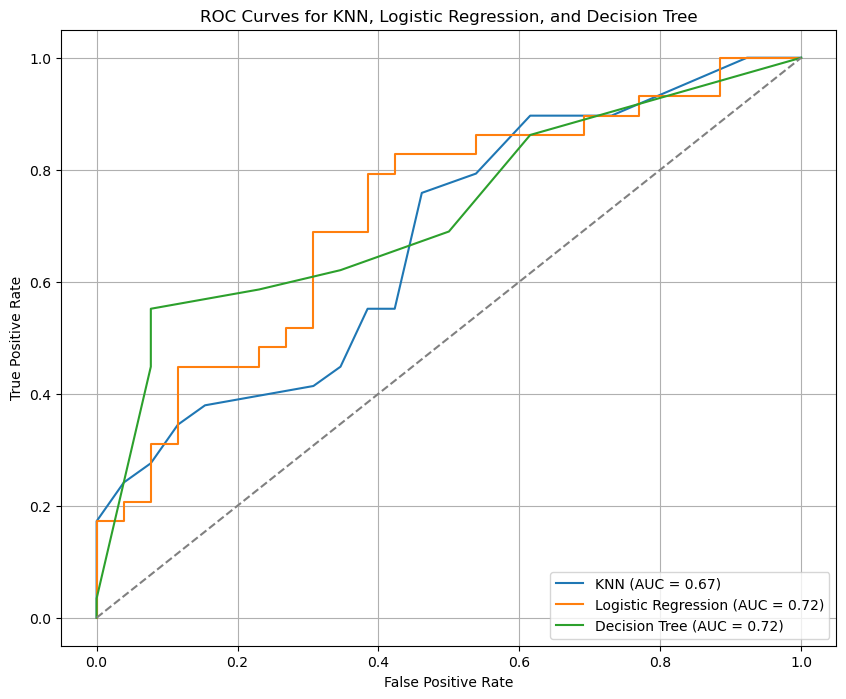

In [37]:
# initializing plot
plt.figure(figsize=(10, 8))

# plotting ROC curve for KNN
y_pred_prob_knn = best_knn.predict_proba(X_test)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')

# plotting ROC curve for Logistic Regression
y_pred_prob_logreg = best_logreg.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_prob_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
plt.plot(fpr_logreg, tpr_logreg, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')

# plotting ROC curve for Decision Tree
y_pred_prob_tree = best_tree.predict_proba(X_test)[:, 1]
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_pred_prob_tree)
roc_auc_tree = auc(fpr_tree, tpr_tree)
plt.plot(fpr_tree, tpr_tree, label=f'Decision Tree (AUC = {roc_auc_tree:.2f})')

# plotting settings
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # diagonal line for random guess
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for KNN, Logistic Regression, and Decision Tree')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Part Two: Metrics

In [27]:
from sklearn.model_selection import cross_val_predict

# function to calculate cross-validated metrics for a given model
def calculate_cross_validated_metrics(model, X, y, cv=5):
    # cross-validated predictions
    y_pred_cv = cross_val_predict(model, X, y, cv=cv)
    
    # calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_pred_cv).ravel()
    
    # calculate metrics
    recall = recall_score(y, y_pred_cv)  # true positive rate (sensitivity)
    precision = precision_score(y, y_pred_cv)  # positive predictive value
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # true negative rate

    # return metrics as dictionary
    return {
        'Recall (Sensitivity)': recall,
        'Precision': precision,
        'Specificity (TNR)': specificity
    }

# calculating cross-validated metrics for each model
metrics_knn_cv = calculate_cross_validated_metrics(best_knn, X, y)
metrics_logreg_cv = calculate_cross_validated_metrics(best_logreg, X, y)
metrics_tree_cv = calculate_cross_validated_metrics(best_tree, X, y)

# displaying metrics
print("Cross-validated Metrics for KNN Model:", metrics_knn_cv)
print("Cross-validated Metrics for Logistic Regression Model:", metrics_logreg_cv)
print("Cross-validated Metrics for Decision Tree Model:", metrics_tree_cv)


Cross-validated Metrics for KNN Model: {'Recall (Sensitivity)': 0.7465753424657534, 'Precision': 0.7956204379562044, 'Specificity (TNR)': 0.7795275590551181}
Cross-validated Metrics for Logistic Regression Model: {'Recall (Sensitivity)': 0.815068493150685, 'Precision': 0.7986577181208053, 'Specificity (TNR)': 0.7637795275590551}
Cross-validated Metrics for Decision Tree Model: {'Recall (Sensitivity)': 0.7328767123287672, 'Precision': 0.7925925925925926, 'Specificity (TNR)': 0.7795275590551181}
Cross-validated Metrics for KNN Model: {'Recall (Sensitivity)': 0.7465753424657534, 'Precision': 0.7956204379562044, 'Specificity (TNR)': 0.7795275590551181}
Cross-validated Metrics for Logistic Regression Model: {'Recall (Sensitivity)': 0.815068493150685, 'Precision': 0.7986577181208053, 'Specificity (TNR)': 0.7637795275590551}
Cross-validated Metrics for Decision Tree Model: {'Recall (Sensitivity)': 0.7328767123287672, 'Precision': 0.7925925925925926, 'Specificity (TNR)': 0.7795275590551181}


# Part Three: Discussion 

## Q1

Metric to Use: In this scenario, the most critical metric is Recall (Sensitivity), which measures the proportion of actual heart attack patients correctly identified by the model. Since the hospital wants to minimize the chance of missing high-risk patients, high recall ensures that the model is sensitive enough to catch most true positives (i.e., patients at risk of a heart attack).

Recommended Model: Based on our cross-validation results, I would recommend the Logistic Regression model. It had a high recall value, indicating it is effective at minimizing false negatives (failing to identify at-risk patients).

Expected Score: I would expect the recall score for Logistic Regression to be approximately the same as our cross-validated recall, which was around 0.81. This means that 81% of patients at risk of a heart attack would be correctly identified.



## Q2

Metric to Use: The appropriate metric here is Precision. Since the hospital wants to efficiently use its limited resources, precision ensures that of all the patients classified as high-risk, a high proportion truly need monitoring. This avoids wasting resources on patients who are not actually at risk.

Recommended Model: I would recommend the KNN model, as it demonstrated a high precision value. This model would reduce the number of false positives, ensuring that patients classified as high-risk are more likely to truly need monitoring.

Expected Score: The expected precision for the KNN model would be around 0.8, based on our cross-validation. This means that 80% of patients identified as high-risk are actually in need of monitoring.



## Q3

Metric to Use: In this scenario, Interpretability is key, rather than a traditional metric. The hospital wants to understand which factors are associated with heart attacks, which makes interpretability of the model and coefficients most important.

Recommended Model: The Logistic Regression model is the best choice here, as it provides interpretable coefficients that can help the hospital understand how each feature (age, chest pain type etc.) contributes to heart attack risk.

Expected Score: While interpretability is the priority, the model's cross validated ROC AUC score (0.893) provides an idea of its overall discriminative ability, which is also reasonably high.



## Q4

Metric to Use: In this scenario, Accuracy is the most straightforward metric to use. The hospital wants to evaluate how well new doctors' diagnoses align with the model, and accuracy provides a direct measure of agreement between predictions and actual labels.

Recommended Model: I would recommend using the Logistic Regression model. Logistic Regression tends to generalize well and provides consistent, interpretable results, making it easier for doctors to understand and compare their own diagnoses against the model's predictions.

Expected Score: I would expect an accuracy score of around 0.80 for Logistic Regression, based on cross-validation. This would indicate that 80% of the predictions align with the true outcomes, providing a solid benchmark for new doctors to compare against.



# Part Four: Validation

In [48]:
# clean validation data
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
ha_validation.dropna(inplace=True)
ha_validation[["sex", "cp", "restecg", "output"]] = ha_validation[["sex", "cp", "restecg", "output"]].astype("object")
ha_validation["output"] = ha_validation["output"].astype(int)

# splitting into features and target
X_val = ha_validation.drop(columns='output')
y_val = ha_validation['output']



In [49]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score

# function to evaluate model on validation data
def evaluate_model_on_validation(model, X_val, y_val):
    # predict and predict probabilities
    y_pred = model.predict(X_val)
    y_pred_prob = model.predict_proba(X_val)[:, 1]

    # calculate confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)
    print("Confusion Matrix:\n", conf_matrix)

    # calculate metrics
    roc_auc = roc_auc_score(y_val, y_pred_prob)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)

    # print metrics
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

# evaluating KNN model on validation set
print("Evaluating KNN Model on Validation Set:")
evaluate_model_on_validation(best_knn, X_val, y_val)

# evaluating Logistic Regression model on validation set
print("\nEvaluating Logistic Regression Model on Validation Set:")
evaluate_model_on_validation(best_logreg, X_val, y_val)

# evaluating Decision Tree model on validation set
print("\nEvaluating Decision Tree Model on Validation Set:")
evaluate_model_on_validation(best_tree, X_val, y_val)


Evaluating KNN Model on Validation Set:
Confusion Matrix:
 [[ 9  2]
 [ 8 11]]
ROC AUC: 0.80
Precision: 0.85
Recall: 0.58

Evaluating Logistic Regression Model on Validation Set:
Confusion Matrix:
 [[ 8  3]
 [ 6 13]]
ROC AUC: 0.85
Precision: 0.81
Recall: 0.68

Evaluating Decision Tree Model on Validation Set:
Confusion Matrix:
 [[ 8  3]
 [ 6 13]]
ROC AUC: 0.76
Precision: 0.81
Recall: 0.68
Evaluating KNN Model on Validation Set:
Confusion Matrix:
 [[ 9  2]
 [ 8 11]]
ROC AUC: 0.80
Precision: 0.85
Recall: 0.58

Evaluating Logistic Regression Model on Validation Set:
Confusion Matrix:
 [[ 8  3]
 [ 6 13]]
ROC AUC: 0.85
Precision: 0.81
Recall: 0.68

Evaluating Decision Tree Model on Validation Set:
Confusion Matrix:
 [[ 8  3]
 [ 6 13]]
ROC AUC: 0.76
Precision: 0.81
Recall: 0.68


In [50]:
# Previously found cross validation metrics
print("Cross-validated Metrics for KNN Model:", metrics_knn_cv)
print("Cross-validated Metrics for Logistic Regression Model:", metrics_logreg_cv)
print("Cross-validated Metrics for Decision Tree Model:", metrics_tree_cv)

print(f"Cross-validated ROC AUC score for KNN: {roc_auc:.3f}")
print(f"Cross-validated ROC AUC score for Logistic Regression: {roc_auc_logreg:.3f}")
print(f"Cross-validated ROC AUC score for Decision Tree: {roc_auc_tree:.3f}")

Cross-validated Metrics for KNN Model: {'Recall (Sensitivity)': 0.7465753424657534, 'Precision': 0.7956204379562044, 'Specificity (TNR)': 0.7795275590551181}
Cross-validated Metrics for Logistic Regression Model: {'Recall (Sensitivity)': 0.815068493150685, 'Precision': 0.7986577181208053, 'Specificity (TNR)': 0.7637795275590551}
Cross-validated Metrics for Decision Tree Model: {'Recall (Sensitivity)': 0.7328767123287672, 'Precision': 0.7925925925925926, 'Specificity (TNR)': 0.7795275590551181}
Cross-validated ROC AUC score for KNN: 0.862
Cross-validated ROC AUC score for Logistic Regression: 0.720
Cross-validated ROC AUC score for Decision Tree: 0.724
Cross-validated Metrics for KNN Model: {'Recall (Sensitivity)': 0.7465753424657534, 'Precision': 0.7956204379562044, 'Specificity (TNR)': 0.7795275590551181}
Cross-validated Metrics for Logistic Regression Model: {'Recall (Sensitivity)': 0.815068493150685, 'Precision': 0.7986577181208053, 'Specificity (TNR)': 0.7637795275590551}
Cross-val

The KNN model performed worse in terms of recall, suggesting it is less sensitive to true positives than initially estimated, but it maintained or even improved in precision. ROC AUC saw a slight decrease. 

The Logistic Regression model experienced a drop in recall but maintained good precision and showed improved ROC AUC on the validation set, indicating it is still a solid, well-generalized model.

The Decision Tree model performed slightly better in terms of precision and ROC AUC on the validation set, though it still had a slight drop in recall, meaning it was less effective at capturing true positives.

Logistic Regression appears to be the best performer, as it balanced precision and ROC AUC quite well, with a smaller decrease in recall compared to the others. The models mostly held up well when comparing cross-validation estimates to validation performance, especially regarding precision and ROC AUC. 

# Part Five: Cohen's Kappa

In [52]:
from sklearn.metrics import cohen_kappa_score

# calculating Cohen's Kappa for KNN Model
y_pred_knn_val = best_knn.predict(X_val)
knn_ck = cohen_kappa_score(y_val, y_pred_knn_val)
print(f"Cohen's Kappa for KNN Model: {knn_ck:.2f}")

# calculating Cohen's Kappa for Logistic Regression Model
y_pred_logreg_val = best_logreg.predict(X_val)
log_ck = cohen_kappa_score(y_val, y_pred_logreg_val)
print(f"Cohen's Kappa for Logistic Regression Model: {log_ck:.2f}")

# calculating Cohen's Kappa for Decision Tree Model
y_pred_tree_val = best_tree.predict(X_val)
tree_ck = cohen_kappa_score(y_val, y_pred_tree_val)
print(f"Cohen's Kappa for Decision Tree Model: {tree_ck:.2f}")


Cohen's Kappa for KNN Model: 0.36
Cohen's Kappa for Logistic Regression Model: 0.39
Cohen's Kappa for Decision Tree Model: 0.39
Cohen's Kappa for KNN Model: 0.36
Cohen's Kappa for Logistic Regression Model: 0.39
Cohen's Kappa for Decision Tree Model: 0.39


Cohen's Kappa is a metric that measures how well the model’s predictions agree with the true labels, taking into account the possibility of random agreement. A high Kappa score indicates that the model's predictions are not just random guesses and align well with the actual values beyond chance. It could be smart to use this metric in a situation where class distributions are imbalanced, and/or standard metrics like accuracy might be misleading. 

The Cohen’s Kappa for the KNN model was relatively low (0.36), which suggests that its level of agreement with the true labels was weak. This reinforces the concern about its ability to generalize and accurately capture the relationship between features and target. Therefore, the conclusion that KNN might not be the best model for this application is unchanged.

The Cohen’s Kappa for Logistic Regression was slightly higher (0.39). While this still indicates only fair agreement, it confirms that Logistic Regression is at least on similar to the other models and is more interpretable. The decision to prefer Logistic Regression, especially for interpretability and consistent generalization, remains valid.

The Cohen’s Kappa for Decision Tree was also 0.39, similar to Logistic Regression. This shows that the Decision Tree model's predictions have a similar level of agreement to those of Logistic Regression. However, considering that Decision Trees tend to overfit and may lack the stability of Logistic Regression, the preference for Logistic Regression is still justified.

While Cohen’s Kappa reveals only fair agreement across all models, Logistic Regression remains the preferred choice due to its balance between performance and interpretability. The low Kappa values indicate a need for further model improvements, possibly through feature engineering, addressing class imbalance, or using more advanced modeling techniques. However, the overall conclusions do not change significantly. Logistic Regression is still the best model among the three for predicting heart attack risk, given its consistency and interpretability.



# Appendix

https://towardsdatascience.com/interpretation-of-kappa-values-2acd1ca7b18f

https://scikit-learn.org/dev/modules/generated/sklearn.metrics.cohen_kappa_score.html

This lab assignment involved the use of ChatGPT as a supplementary tool to aid in coding, debugging, and generating ideas for data analysis. ChatGPT was utilized to provide guidance in structuring the analysis and understanding specific machine learning concepts, but all code implementation, data cleaning, model training, and interpretation of results were conducted independently by the author. The AI tool was used primarily for conceptual clarification and brainstorming purposes, and not for direct generation of assignment content.